In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_16404\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

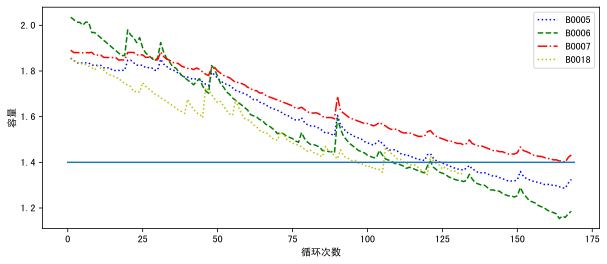

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    src_list, tgt_list, tgt_y_list = [], [], []
    for i in range(len(text) - window_size):
        src = text[i:i + window_size]
        src = [0] + src + [1]
        
        tgt = text[i + window_size:-1]
        tgt_y = text[i + window_size + 1:]
        
        tgt = [0] + tgt + [1] + [2] * (153 - 2 - len(tgt))
        tgt_y = [0] + tgt_y + [1] + [2] * (153 - 2 - len(tgt_y))
        
        src_list.append(src)
        tgt_list.append(tgt)
        tgt_y_list.append(tgt_y)

    return np.array(src_list), np.array(tgt_list), np.array(tgt_y_list)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    train_data = [0] + train_data + [1]
    
    train_src, train_tgt, train_tgt_y = None, None, None
    for k, v in data_dict.items():
        if k != name:
            data_src, data_tgt, data_tgt_y = build_seq(text=v[1], window_size=window_size)
            if train_src is None:
                train_src = data_src
                train_tgt = data_tgt
                train_tgt_y = data_tgt_y
            else:
                train_src = np.r_[train_src, data_src]
                train_tgt = np.r_[train_tgt, data_tgt]
                train_tgt_y = np.r_[train_tgt_y, data_tgt_y]
                
    return train_src, train_tgt, train_tgt_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [7]:
train_src, train_tgt, train_tgt_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_src = torch.from_numpy(train_src.astype(np.float32))
train_tgt = torch.from_numpy(train_tgt.astype(np.float32))
train_tgt_y = torch.from_numpy(train_tgt_y.astype(np.float32))
train_iter = load_capacity_data((train_src, train_tgt, train_tgt_y), 50, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for src, tgt, tgt_y in train_iter:
        print(src.shape)
        print(tgt.shape)
        print(tgt_y.shape)
        #print(tgt[0])
        #print(tgt_y[1])
        print(tgt_y[:, 1].shape)
        break



validate_train_iter(train_iter)

torch.Size([50, 18])
torch.Size([50, 153])
torch.Size([50, 153])
torch.Size([50])


In [8]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

In [9]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

In [10]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512):
        super(Net, self).__init__()

        # 定义Transformer。超参是我拍脑袋想的
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, 
                                          num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, 
                                          dim_feedforward=dim_feedforward, batch_first=True)
        
        self.linear_embedding_src = nn.Linear(1, d_model)
        self.linear_embedding_tgt = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model, 1)

    def forward(self, src, tgt):
        # print('src.shape', src.shape)
        # 生成mask
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size()[-1]).to(device)
        src_key_padding_mask = Net.get_key_padding_mask(src).to(device)
        tgt_key_padding_mask = Net.get_key_padding_mask(tgt).to(device)
        

        # 对src和tgt进行编码
        src = src.reshape(src.shape[0], src.shape[1], 1)
        tgt = tgt.reshape(tgt.shape[0], tgt.shape[1], 1)
        
        src = self.linear_embedding_src(src)
        tgt = self.linear_embedding_tgt(tgt)
        
        # 给src和tgt的token增加位置信息
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        
        # print(tgt_mask.dtype)
        # print(src_key_padding_mask.dtype)
        # print(tgt_key_padding_mask.dtype)
        # 将准备好的数据送给transformer
        out = self.transformer(src, tgt,
                               tgt_mask=tgt_mask,
                               src_key_padding_mask=src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask)

        """
        这里直接返回transformer的结果。因为训练和推理时的行为不一样，
        所以在该模型外再进行线性层的预测。
        """
        
        out = self.predictor(out)
        
        return out

    @staticmethod
    def get_key_padding_mask(tokens):
        """
        用于key_padding_mask
        """
        key_padding_mask = torch.zeros(tokens.size())
        key_padding_mask[tokens == 2] = -torch.inf
        return key_padding_mask.to(torch.bool)

In [13]:
# 测试模型的输出形状
model = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
src = torch.ones((1, 18), dtype=torch.float32).to(device)

# tgt = torch.LongTensor([[3, 4, 5, 6, 1, 2, 2]])
tgt = torch.ones((1, 154), dtype=torch.float32).to(device)

out = model(src, tgt)
print(out.size())

torch.Size([1, 154, 1])


In [14]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for src, tgt, tgt_y in train_iter:
        # 计算梯度并更新参数
        src = torch.reshape(src, (-1, src.shape[-1])).type(torch.float32)
        tgt = torch.reshape(tgt, (-1, tgt.shape[-1])).type(torch.float32)
        tgt_y = torch.reshape(tgt_y, (-1, tgt_y.shape[-1])).type(torch.float32)
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(src, tgt)
        
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), tgt_y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l, out[0, :, :].reshape(-1).cpu().data.numpy(), tgt_y[0, :].reshape(-1).cpu().data.numpy()

In [15]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss, out, tgt_y = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, Rated_Capacity)
            tgt_y = test_data.copy()[1:]
            
            mae, rmse = evaluation(tgt_y, pre_list)
            re = relative_error(tgt_y, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            # print('out is ')
            # print(len(out))
            # print('tgt_y is ')
            # print(len(tgt_y))
            
            
            matlab_make(pre_list, tgt_y)
            
            #print('epoch:{:<4d} , loss:{:<6.10f} '.format(epoch, train_loss))
            
#             if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
#                 break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

tensor([-2.3605e-04,  1.8018e+00,  1.7927e+00,  1.7921e+00,  1.8475e+00,
         1.8488e+00,  1.8338e+00,  1.8194e+00,  1.8187e+00,  1.8201e+00,
         1.8078e+00,  1.8090e+00,  1.8078e+00,  1.7951e+00,  1.7972e+00,
         1.8535e+00,  1.8280e+00,  1.8148e+00,  1.8019e+00,  1.7925e+00,
         1.7869e+00,  1.7794e+00,  1.7761e+00,  1.7663e+00,  1.7671e+00,
         1.7598e+00,  1.7525e+00,  1.7622e+00,  1.7571e+00,  1.7420e+00,
         1.7318e+00,  1.7268e+00,  1.7964e+00,  1.7878e+00,  1.7675e+00,
         1.7525e+00,  1.7408e+00,  1.7347e+00,  1.7285e+00,  1.7187e+00,
         1.7085e+00,  1.7020e+00,  1.6979e+00,  1.6920e+00,  1.6843e+00,
         1.6764e+00,  1.6691e+00,  1.6697e+00,  1.6582e+00,  1.6540e+00,
         1.6494e+00,  1.6385e+00,  1.6357e+00,  1.6330e+00,  1.6274e+00,
         1.6206e+00,  1.6083e+00,  1.6025e+00,  1.5983e+00,  1.5886e+00,
         1.5847e+00,  1.5836e+00,  1.5925e+00,  1.5706e+00,  1.5620e+00,
         1.5584e+00,  1.5590e+00,  1.5550e+00,  1.5

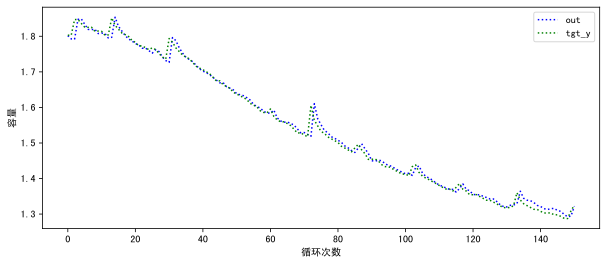

In [14]:
# 采用真实数据作为tgt 来预测 tgt_y
net = net.eval()

data_sequence = Battery[Battery_list[0]][1]
train_data, test_data = data_sequence[:16], data_sequence[16:]
train_data = [0] + train_data + [1]

# print(len(train_data))
# print(len(test_data))

src = train_data.copy()
src = np.array(src)
src = torch.from_numpy(src).to(device)
src = torch.reshape(src, (-1, 18)).type(torch.float32)
# print(src)

tgt = test_data.copy()[:-1]
tgt = [0] + tgt + [1]
# print('tgt.shape', len(tgt))
tgt = np.array(tgt)
# print('tgt.shape', tgt.shape)
tgt = torch.from_numpy(tgt).to(device)
# print('tgt.shape', tgt.shape)
tgt = torch.reshape(tgt, (1, -1)).type(torch.float32)
# print('tgt.shape', tgt.shape)

out = net(src, tgt)
# print(out)
# print(out.shape)

pred = net.predictor(out)
# pred = net.predictor(out[:, -1])

# print(pred.reshape(-1, 1))
pred = pred.reshape(-1)
print(pred)
print(pred.shape)

# print(tgt.shape)
# print(pred.shape)
# tgt = torch.concat([tgt, pred], dim=1)


# print(tgt)
# print(tgt.shape)

tgt_y = test_data.copy()[1:]

matlab_make(pred.cpu().data.numpy()[1:-1], tgt_y)


In [43]:
# 采用预测出来的数据作为tgt 来预测 tgt_y
net = net.eval()

data_sequence = Battery[Battery_list[0]][1]
train_data, test_data = data_sequence[:16], data_sequence[16:]
train_data = [0] + train_data + [1]

# print(len(train_data))
# print(len(test_data))

src = train_data.copy()
src = np.array(src)
src = torch.from_numpy(src).to(device)
src = torch.reshape(src, (-1, 18)).type(torch.float32)
# print(src)

tgt = test_data.copy()[:-1]
tgt = [0] + tgt[0:1] + [1.8018, 1.7913, 1.7798, 1.7710, 1.7634, 1.7551] + [1]
# tgt = [0] + [1.8018] + [1]
# print('tgt.shape', len(tgt))
tgt = np.array(tgt)
# print('tgt.shape', tgt.shape)
tgt = torch.from_numpy(tgt).to(device)
# print('tgt.shape', tgt.shape)
tgt = torch.reshape(tgt, (1, -1)).type(torch.float32)
# print('tgt.shape', tgt.shape)

out = net(src, tgt)
# print(out)
# print(out.shape)

pred = net.predictor(out)
# pred = net.predictor(out[:, -1])

# print(pred.reshape(-1, 1))
pred = pred.reshape(-1)
print(pred)
print(pred.shape)

# print(tgt.shape)
# print(pred.shape)
# tgt = torch.concat([tgt, pred], dim=1)


# print(tgt)
# print(tgt.shape)

# tgt_y = test_data.copy()[1:]

# matlab_make(pred.cpu().data.numpy()[1:-1], tgt_y)

tensor([-2.3605e-04,  1.8018e+00,  1.7913e+00,  1.7798e+00,  1.7710e+00,
         1.7634e+00,  1.7551e+00,  1.7449e+00,  9.8831e-01], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
torch.Size([9])


In [16]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    src = train_data.copy()
    src = np.array(src)
    src = torch.from_numpy(src).to(device)
    src = torch.reshape(src, (-1, 18)).type(torch.float32) # shape: (batch_size, input_size)
    
    tgt_list = [0] + test_data[0:1] + [1]
    
    
    tgt = torch.Tensor([[0]]).type(torch.float32).to(device)
    while len(tgt_list) - 2 < len(test_data) - 1:
        tgt = np.array(tgt_list)
        tgt = torch.from_numpy(tgt).to(device)
        tgt = torch.reshape(tgt, (1, -1)).type(torch.float32)
        
        pred = net(src, tgt)
        pred = pred.reshape(-1)
        
        # print('------现在的tgt_list的长度是------', len(tgt_list))
        # print('tgt_list 是', tgt_list)
        # print('pred 是', pred)
        # print('pred.shape 是', pred.shape)
        # print()
        
        tgt_list = tgt_list[:-1] + [pred.cpu().data.numpy()[-2]] + [1]
        
        # print(tgt.shape)
        # print(pred.shape)
        # tgt = torch.concat([tgt, pred], dim=1)  # 测试值加入原来序列用来继续预测下一个点
        
        # tgt_y = test_data.copy()[1:]
        
    return tgt_list[1:-1]
        
    
# tgt_y = test_data.copy()[1:]
# tgt_list = predict(net, train_data, test_data, Rated_Capacity)
# matlab_make(tgt_list, tgt_y)
# print(len(tgt_list))
# print(len(tgt_y))

以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0121862711 , MAE:0.3440 , RMSE:0.4078 , RE:0.3981


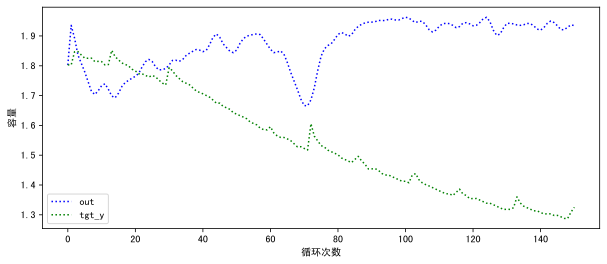

epoch:199  , loss:0.0057071014 , MAE:0.3540 , RMSE:0.4106 , RE:0.3981


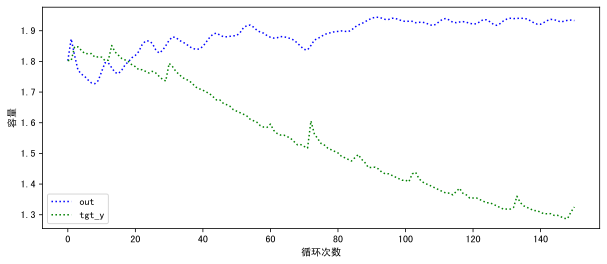

epoch:299  , loss:0.0034134286 , MAE:0.3206 , RMSE:0.3844 , RE:0.3981


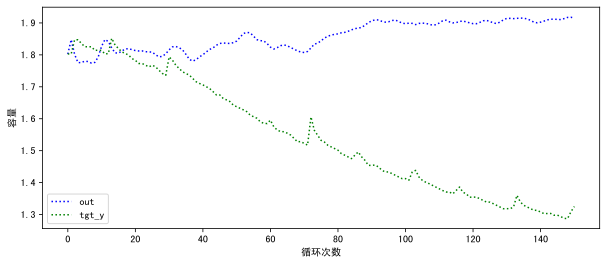

epoch:399  , loss:0.0026457529 , MAE:0.2909 , RMSE:0.3623 , RE:0.3981


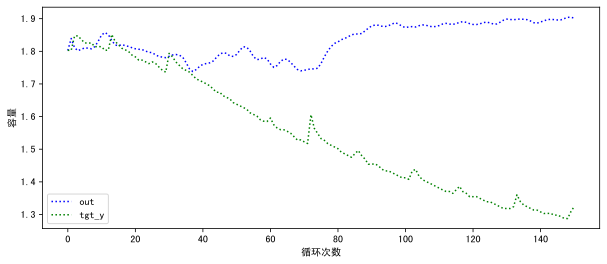

epoch:499  , loss:0.0020350316 , MAE:0.2696 , RMSE:0.3561 , RE:0.3981


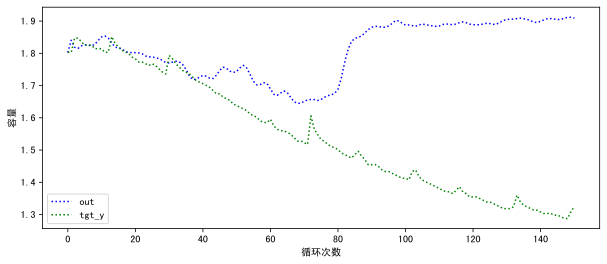

epoch:599  , loss:0.0016847705 , MAE:0.2722 , RMSE:0.3621 , RE:0.3981


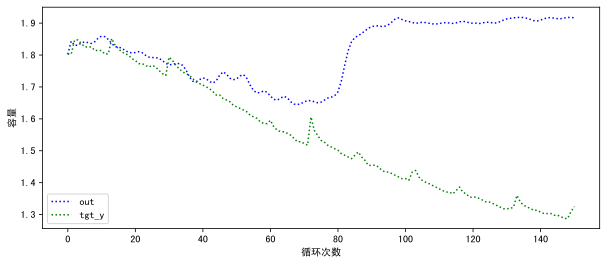

epoch:699  , loss:0.0010647069 , MAE:0.2799 , RMSE:0.3674 , RE:0.3981


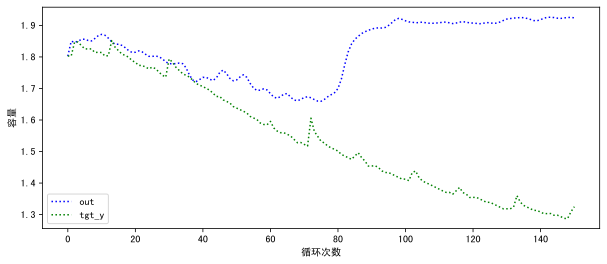

epoch:799  , loss:0.0009033743 , MAE:0.2785 , RMSE:0.3742 , RE:0.3981


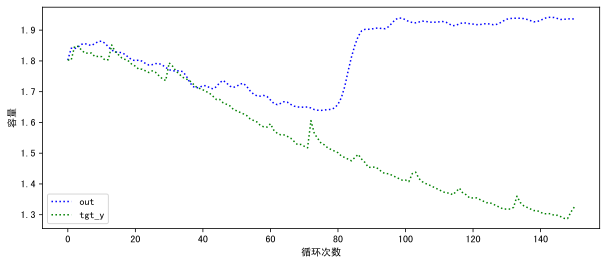

epoch:899  , loss:0.0007038882 , MAE:0.2813 , RMSE:0.3853 , RE:0.3981


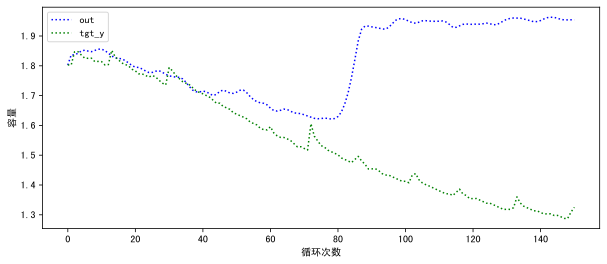

epoch:999  , loss:0.0005613369 , MAE:0.2913 , RMSE:0.3966 , RE:0.3981


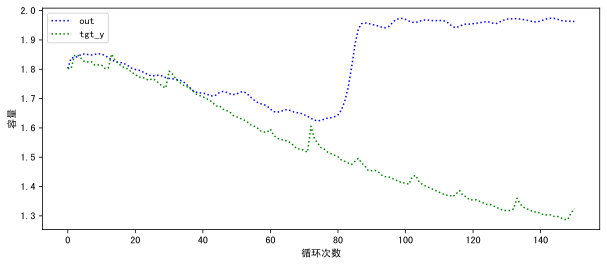

epoch:1099 , loss:0.0005163433 , MAE:0.3075 , RMSE:0.4061 , RE:0.3981


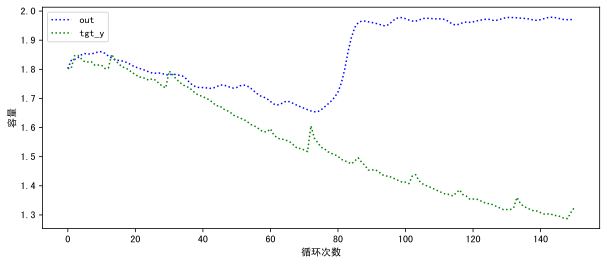

epoch:1199 , loss:0.0004081816 , MAE:0.2994 , RMSE:0.4080 , RE:0.3981


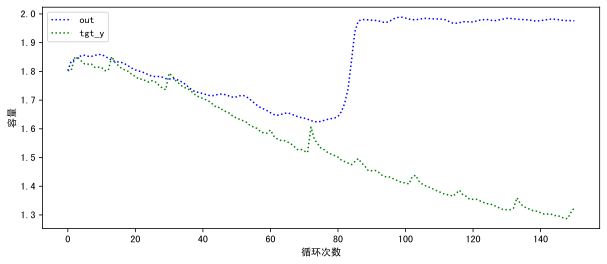

epoch:1299 , loss:0.0003215553 , MAE:0.2994 , RMSE:0.4111 , RE:0.3981


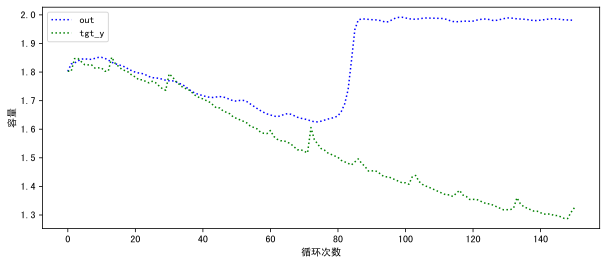

epoch:1399 , loss:0.0003345424 , MAE:0.2940 , RMSE:0.4113 , RE:0.3981


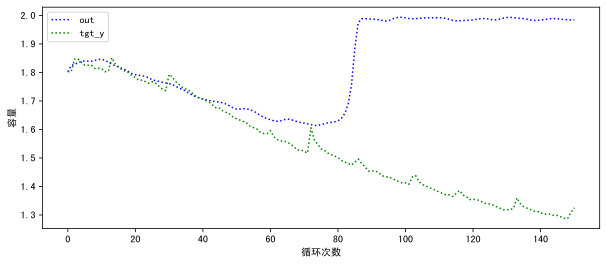

epoch:1499 , loss:0.0002746021 , MAE:0.2906 , RMSE:0.4122 , RE:0.3981


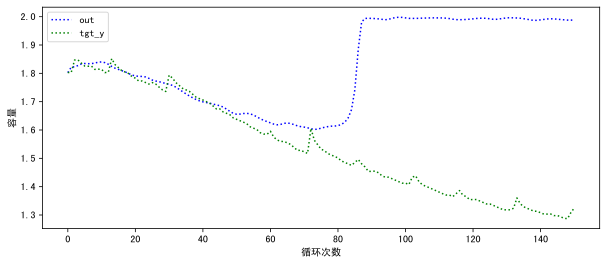

epoch:1599 , loss:0.0002544425 , MAE:0.3002 , RMSE:0.4169 , RE:0.3981


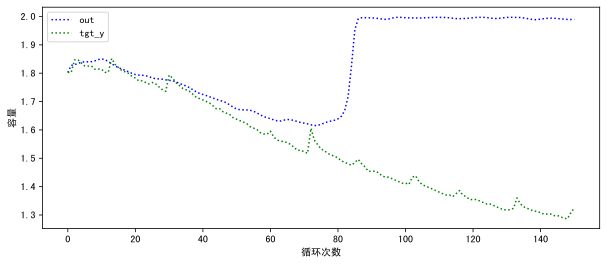

epoch:1699 , loss:0.0003114438 , MAE:0.0795 , RMSE:0.1017 , RE:0.3981


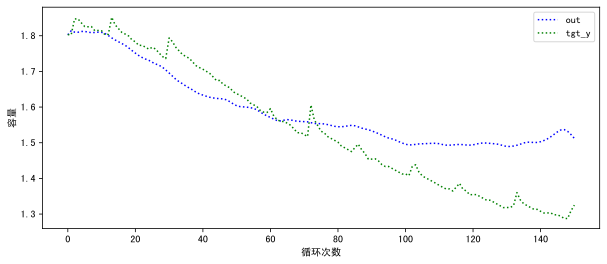

epoch:1799 , loss:0.0002395609 , MAE:0.1589 , RMSE:0.2680 , RE:0.3981


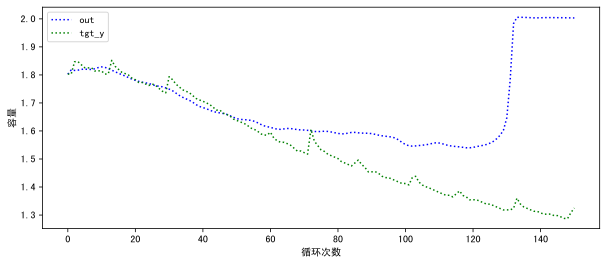

epoch:1899 , loss:0.0002382760 , MAE:0.0898 , RMSE:0.1067 , RE:0.3981


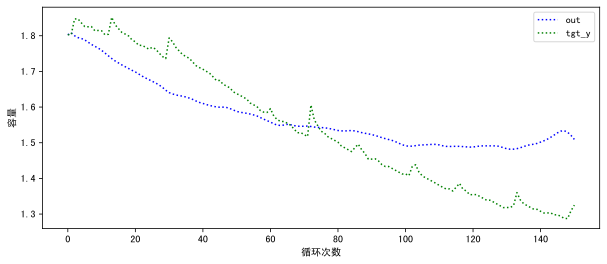

epoch:1999 , loss:0.0002611943 , MAE:0.2599 , RMSE:0.3863 , RE:0.3981


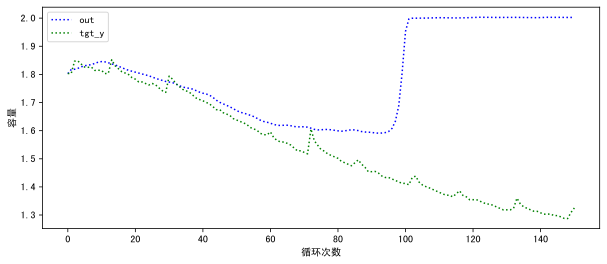

以电池 B0006 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0236508399 , MAE:0.3023 , RMSE:0.3838 , RE:0.6413


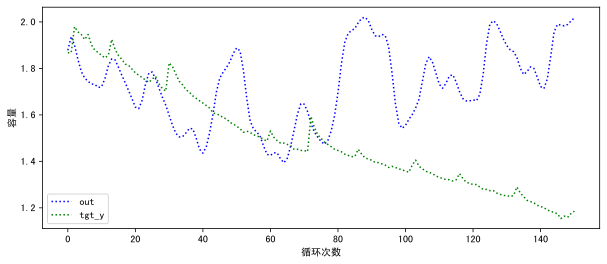

epoch:199  , loss:0.0068177762 , MAE:0.3524 , RMSE:0.4126 , RE:0.6413


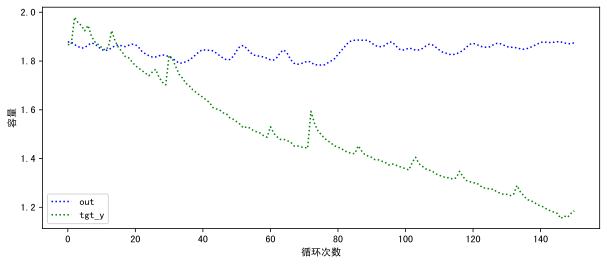

epoch:299  , loss:0.0044588493 , MAE:0.3753 , RMSE:0.4342 , RE:0.6413


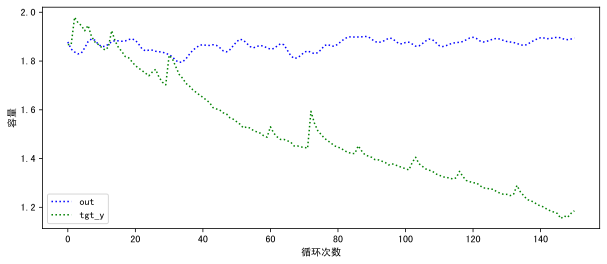

epoch:399  , loss:0.0032446720 , MAE:0.3811 , RMSE:0.4420 , RE:0.6413


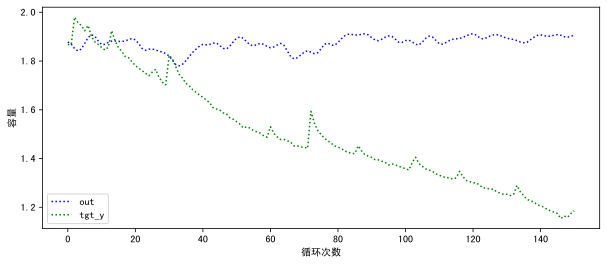

epoch:499  , loss:0.0024906504 , MAE:0.3790 , RMSE:0.4415 , RE:0.6413


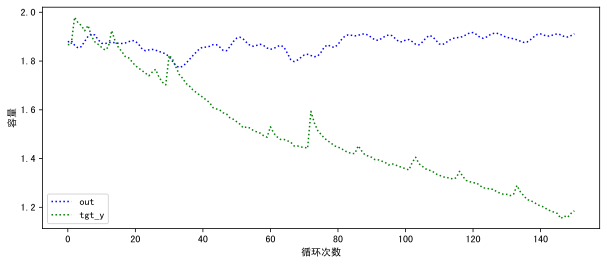

epoch:599  , loss:0.0018535376 , MAE:0.3740 , RMSE:0.4377 , RE:0.6413


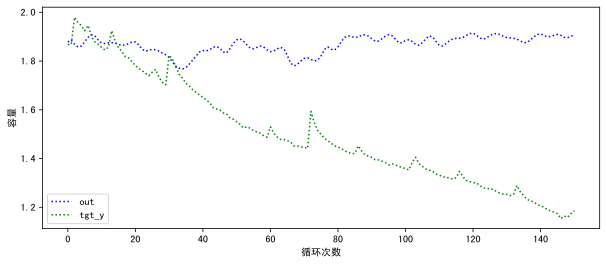

epoch:699  , loss:0.0012687547 , MAE:0.3666 , RMSE:0.4336 , RE:0.6413


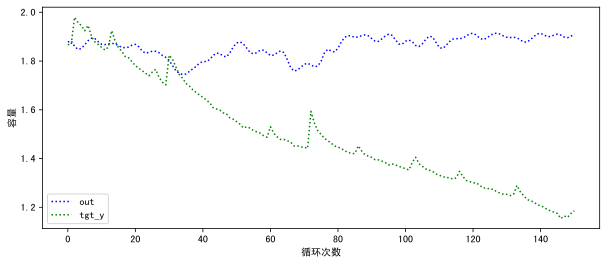

epoch:799  , loss:0.0013891647 , MAE:0.3656 , RMSE:0.4352 , RE:0.6413


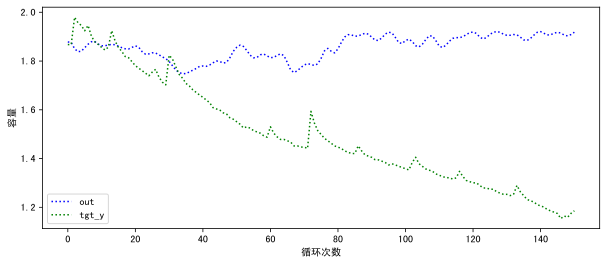

epoch:899  , loss:0.0011418897 , MAE:0.3663 , RMSE:0.4388 , RE:0.6413


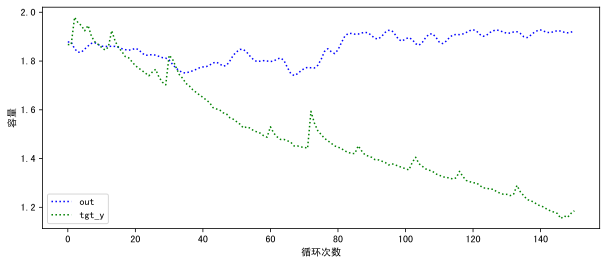

epoch:999  , loss:0.0006881431 , MAE:0.3649 , RMSE:0.4401 , RE:0.6413


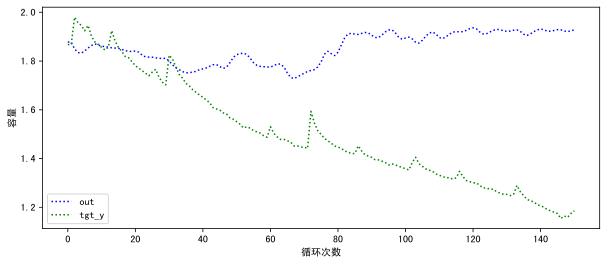

epoch:1099 , loss:0.0007324596 , MAE:0.3681 , RMSE:0.4431 , RE:0.6413


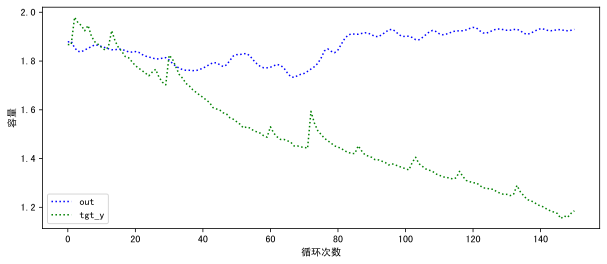

epoch:1199 , loss:0.0004958699 , MAE:0.3720 , RMSE:0.4485 , RE:0.6413


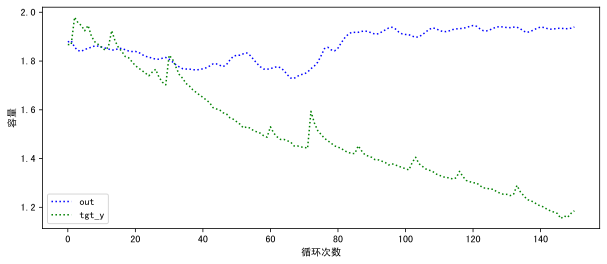

epoch:1299 , loss:0.0003996939 , MAE:0.3744 , RMSE:0.4521 , RE:0.6413


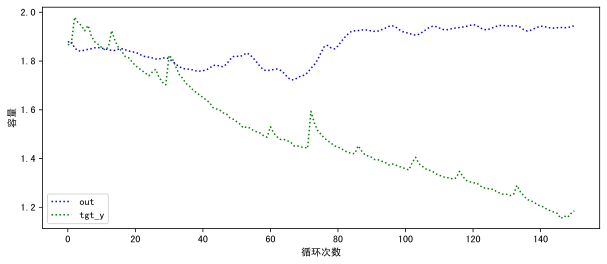

epoch:1399 , loss:0.0004054063 , MAE:0.3778 , RMSE:0.4573 , RE:0.6413


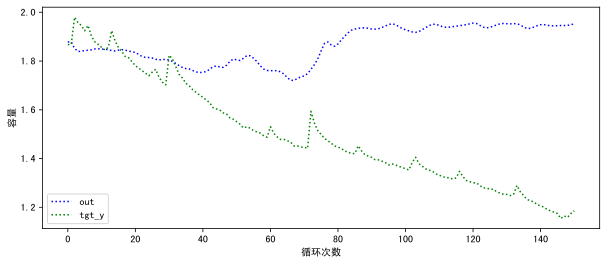

epoch:1499 , loss:0.0003072802 , MAE:0.3798 , RMSE:0.4626 , RE:0.6413


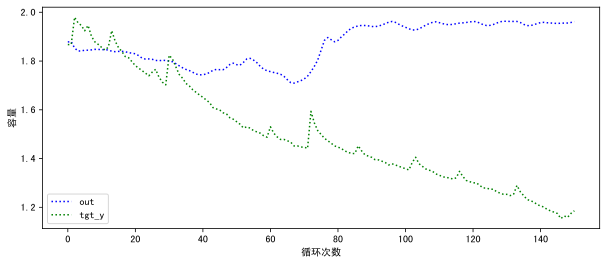

epoch:1599 , loss:0.0002673508 , MAE:0.3791 , RMSE:0.4667 , RE:0.6413


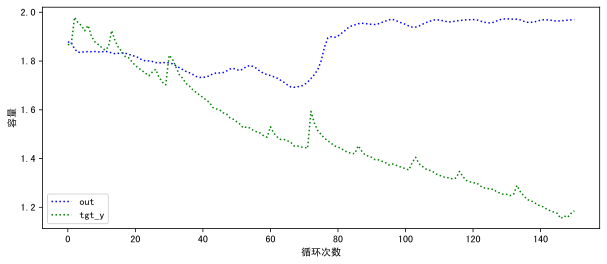

epoch:1699 , loss:0.0002799864 , MAE:0.3884 , RMSE:0.4743 , RE:0.6413


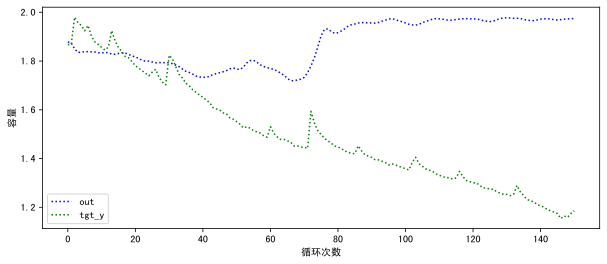

epoch:1799 , loss:0.0002126965 , MAE:0.3975 , RMSE:0.4813 , RE:0.6413


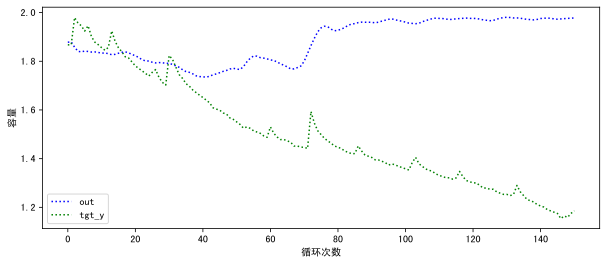

epoch:1899 , loss:0.0002358951 , MAE:0.2239 , RMSE:0.3261 , RE:0.6413


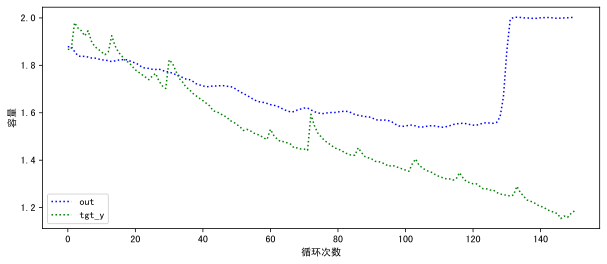

epoch:1999 , loss:0.0001891290 , MAE:0.1031 , RMSE:0.1235 , RE:0.6413


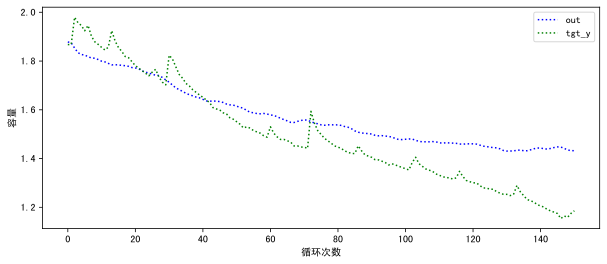

以电池 B0007 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0089113554 , MAE:0.1281 , RMSE:0.1906 , RE:0.0000


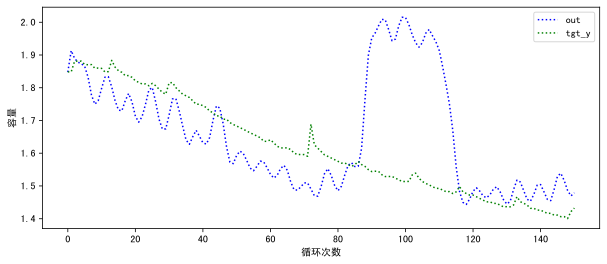

epoch:199  , loss:0.0033582016 , MAE:0.1455 , RMSE:0.1838 , RE:0.0000


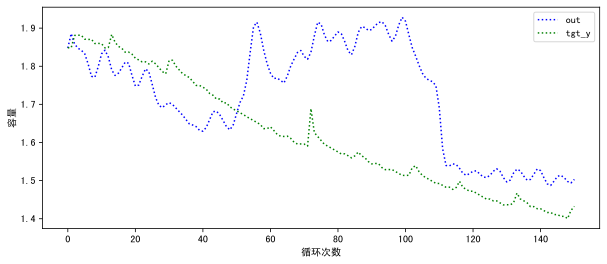

epoch:299  , loss:0.0023613861 , MAE:0.1097 , RMSE:0.1506 , RE:0.0000


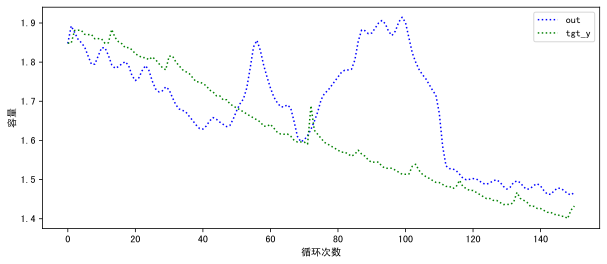

epoch:399  , loss:0.0018105522 , MAE:0.1122 , RMSE:0.1696 , RE:0.0000


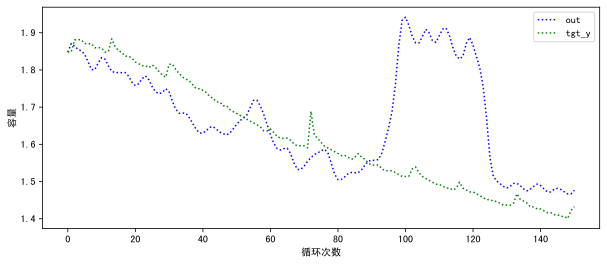

epoch:499  , loss:0.0015880931 , MAE:0.1485 , RMSE:0.2025 , RE:0.0000


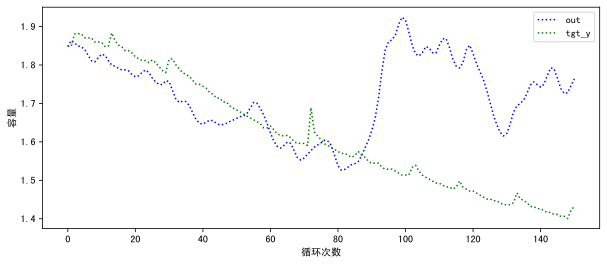

epoch:599  , loss:0.0011187516 , MAE:0.1753 , RMSE:0.2472 , RE:0.0000


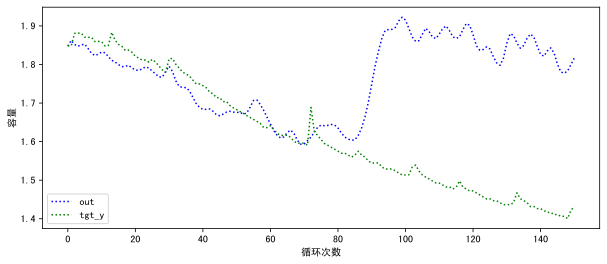

epoch:699  , loss:0.0009125615 , MAE:0.2036 , RMSE:0.2761 , RE:0.0000


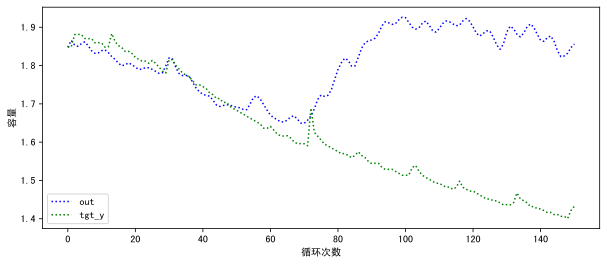

epoch:799  , loss:0.0006525529 , MAE:0.1941 , RMSE:0.2926 , RE:0.0000


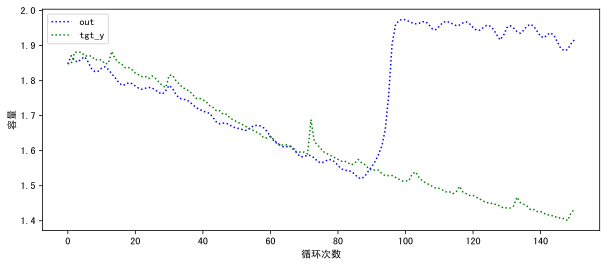

epoch:899  , loss:0.0005464219 , MAE:0.2332 , RMSE:0.3110 , RE:0.0000


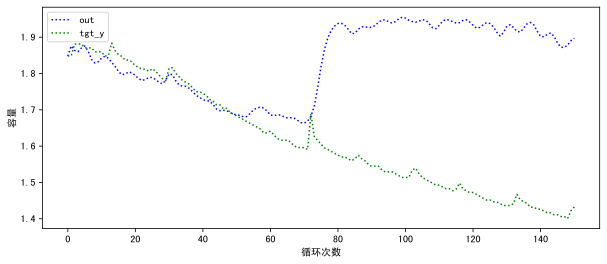

epoch:999  , loss:0.0005281202 , MAE:0.2338 , RMSE:0.3212 , RE:0.0000


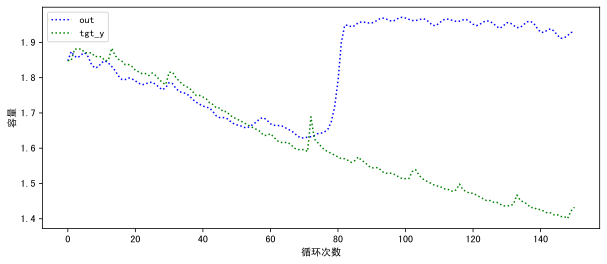

epoch:1099 , loss:0.0003955029 , MAE:0.2402 , RMSE:0.3296 , RE:0.0000


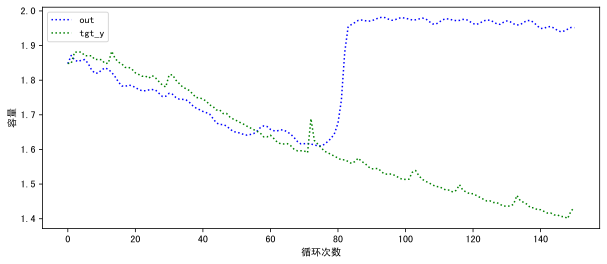

epoch:1199 , loss:0.0003736246 , MAE:0.0874 , RMSE:0.0934 , RE:0.2980


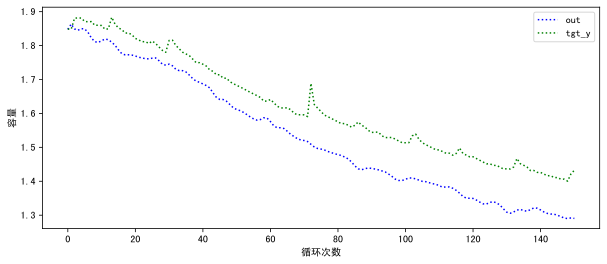

epoch:1299 , loss:0.0004036822 , MAE:0.1089 , RMSE:0.1147 , RE:0.3576


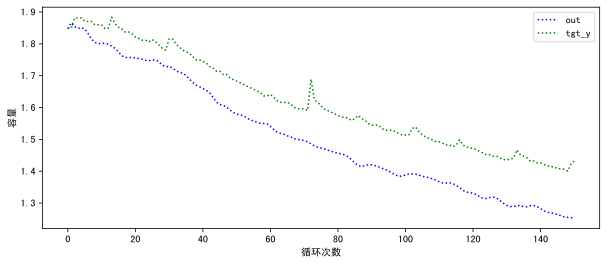

epoch:1399 , loss:0.0002520960 , MAE:0.0987 , RMSE:0.1028 , RE:0.3510


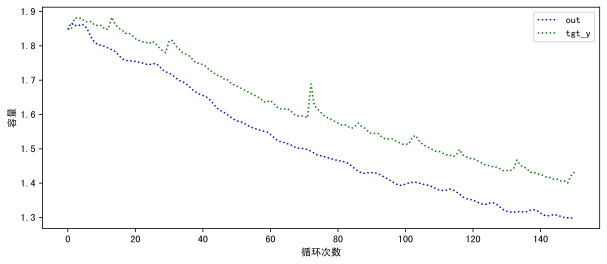

epoch:1499 , loss:0.0002707065 , MAE:0.1538 , RMSE:0.1599 , RE:0.4238


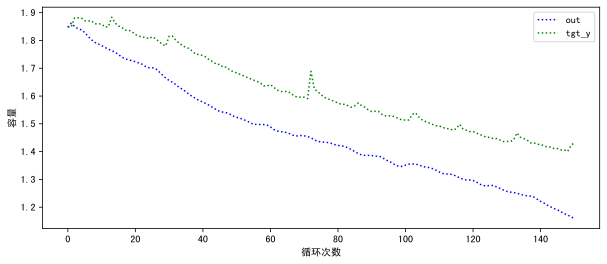

epoch:1599 , loss:0.0002327136 , MAE:0.0876 , RMSE:0.0925 , RE:0.3444


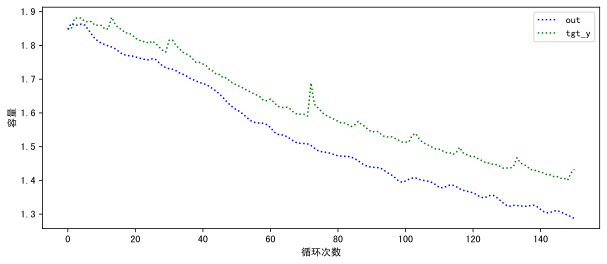

epoch:1699 , loss:0.0002132389 , MAE:0.0967 , RMSE:0.1026 , RE:0.3444


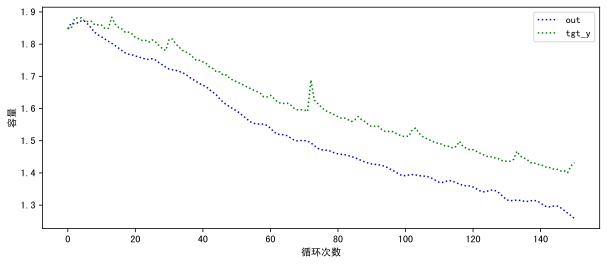

epoch:1799 , loss:0.0002080664 , MAE:0.1496 , RMSE:0.1555 , RE:0.4106


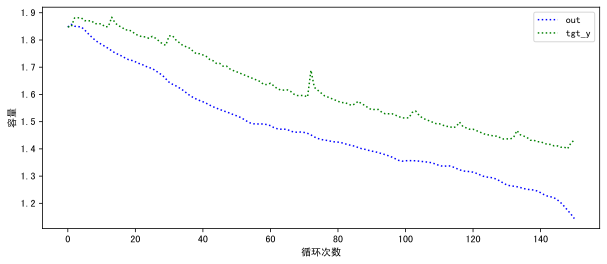

epoch:1899 , loss:0.0001693232 , MAE:0.1713 , RMSE:0.1793 , RE:0.4437


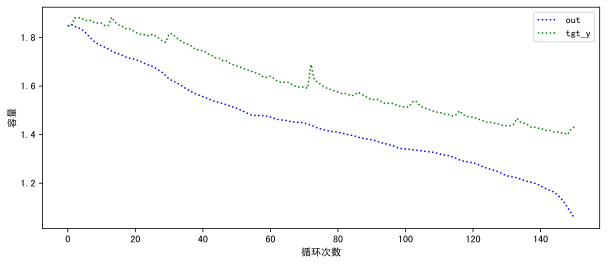

epoch:1999 , loss:0.0001609689 , MAE:0.1267 , RMSE:0.1320 , RE:0.3841


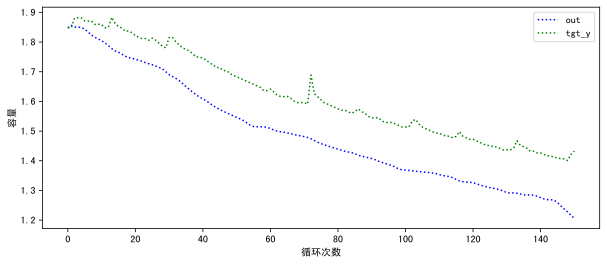

以电池 B0018 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0109645436 , MAE:0.2363 , RMSE:0.2983 , RE:0.4375


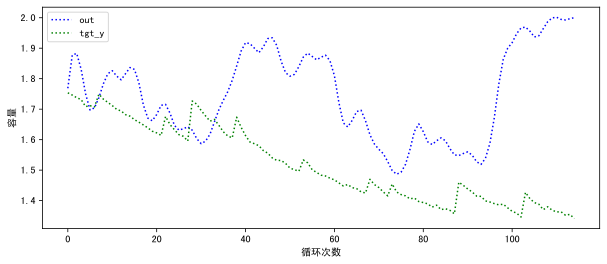

epoch:199  , loss:0.0046094772 , MAE:0.3273 , RMSE:0.3733 , RE:0.4375


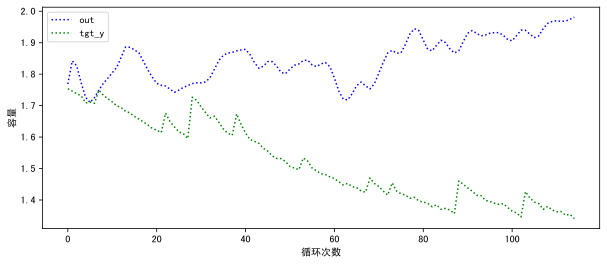

epoch:299  , loss:0.0028572057 , MAE:0.3044 , RMSE:0.3516 , RE:0.4375


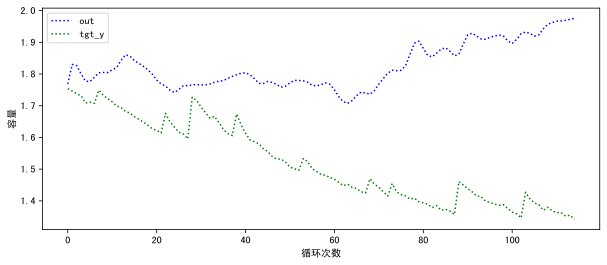

epoch:399  , loss:0.0030100204 , MAE:0.2988 , RMSE:0.3418 , RE:0.4375


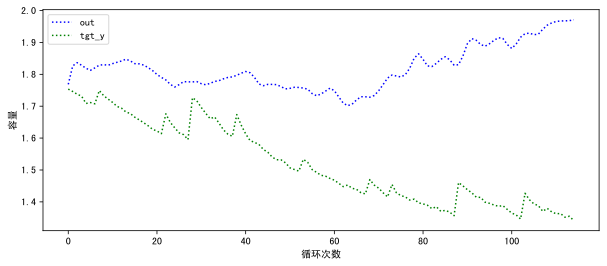

epoch:499  , loss:0.0019211336 , MAE:0.2916 , RMSE:0.3327 , RE:0.4375


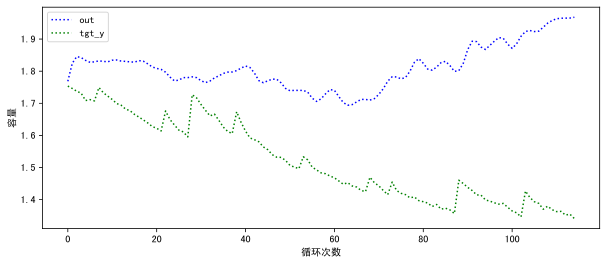

epoch:599  , loss:0.0016396883 , MAE:0.2753 , RMSE:0.3197 , RE:0.4375


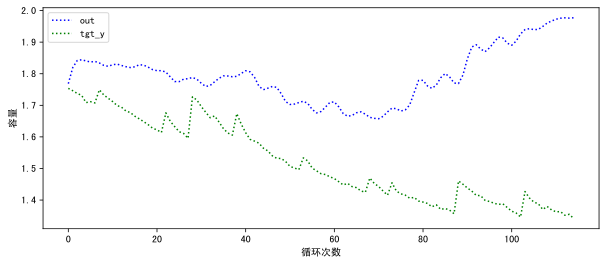

epoch:699  , loss:0.0009352696 , MAE:0.2633 , RMSE:0.3116 , RE:0.4375


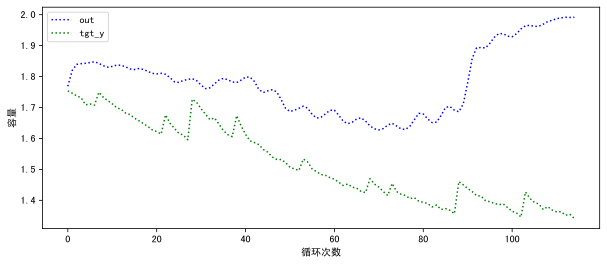

epoch:799  , loss:0.0008899511 , MAE:0.2961 , RMSE:0.3358 , RE:0.4375


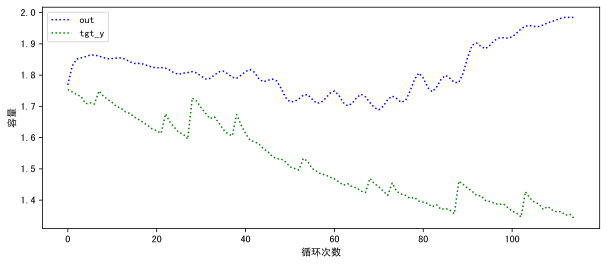

epoch:899  , loss:0.0005431829 , MAE:0.3014 , RMSE:0.3426 , RE:0.4375


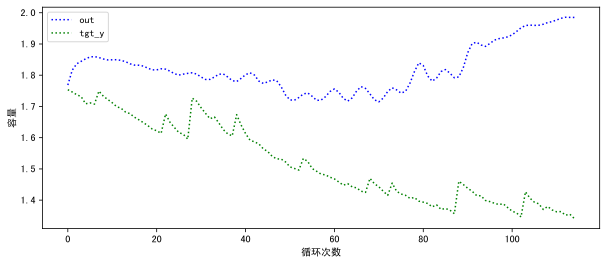

epoch:999  , loss:0.0005528168 , MAE:0.3222 , RMSE:0.3632 , RE:0.4375


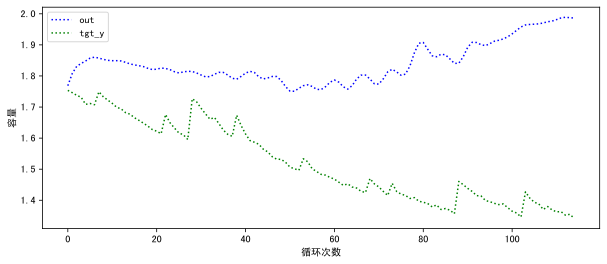

epoch:1099 , loss:0.0004276376 , MAE:0.3366 , RMSE:0.3813 , RE:0.4375


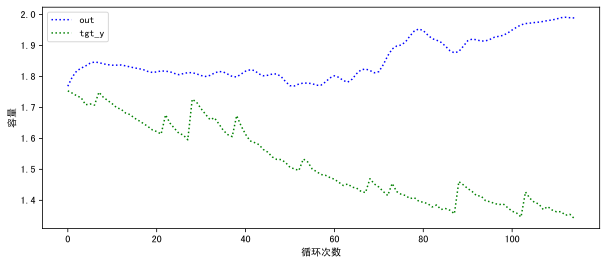

epoch:1199 , loss:0.0004902917 , MAE:0.3481 , RMSE:0.3958 , RE:0.4375


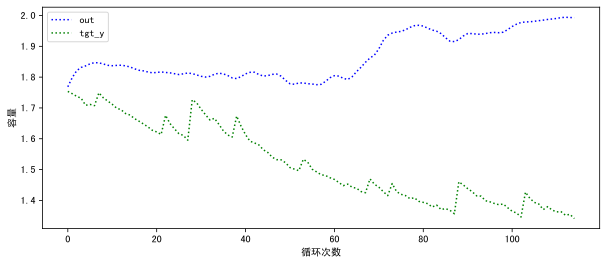

epoch:1299 , loss:0.0004442307 , MAE:0.1840 , RMSE:0.2317 , RE:0.4375


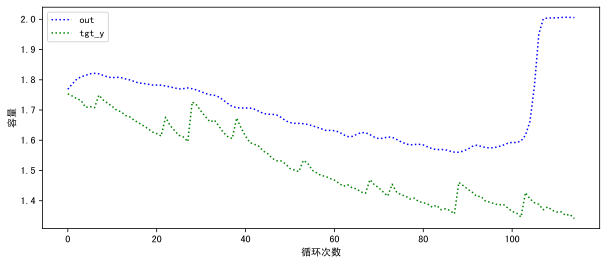

epoch:1399 , loss:0.0002312585 , MAE:0.3447 , RMSE:0.4007 , RE:0.4375


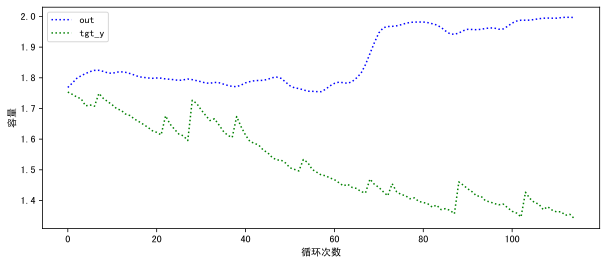

epoch:1499 , loss:0.0002884346 , MAE:0.3748 , RMSE:0.4225 , RE:0.4375


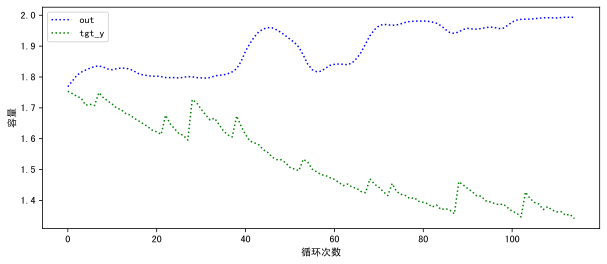

epoch:1599 , loss:0.0002351096 , MAE:0.3879 , RMSE:0.4322 , RE:0.4375


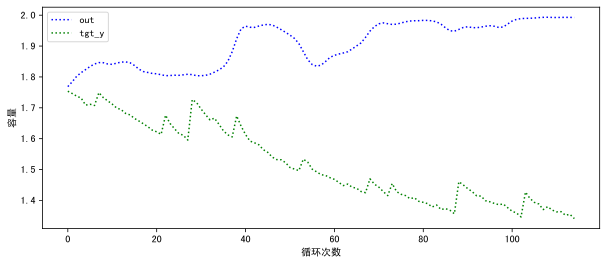

epoch:1699 , loss:0.0002820181 , MAE:0.1788 , RMSE:0.2217 , RE:0.4375


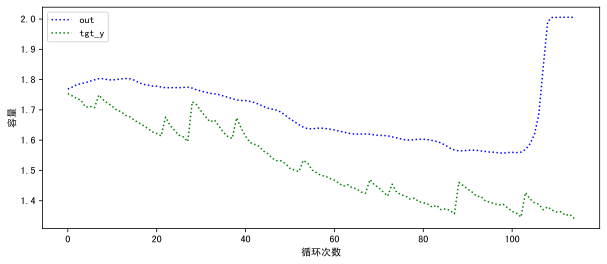

epoch:1799 , loss:0.0002605988 , MAE:0.0325 , RMSE:0.0389 , RE:0.1500


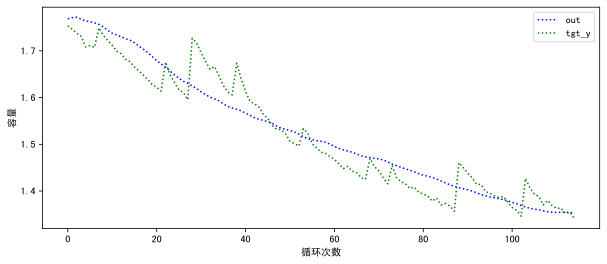

epoch:1899 , loss:0.0002062201 , MAE:0.3911 , RMSE:0.4418 , RE:0.4375


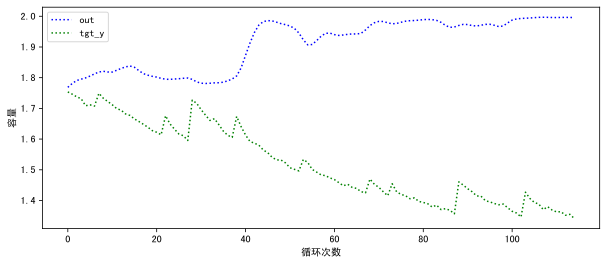

epoch:1999 , loss:0.0002915936 , MAE:0.0342 , RMSE:0.0416 , RE:0.2000


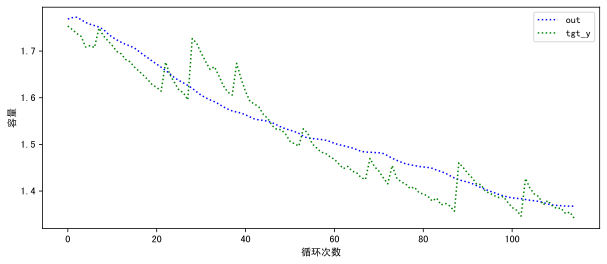

---------------------------------
re_s [0.39814814814814814, 0.6413043478260869, 0.3841059602649007, 0.2]
---------------------------------
re mean: 0.4058896140597839
mae mean: 0.13097528393217123
rmse mean: 0.1708223545522276
---------------------------------


In [17]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 4 
num_decoder_layers = 4
dim_feedforward = 64

batch_size = 50
lr = 0.0001
weight_decay = 0.00001
num_epochs = 2000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
# for i in range(1):
    train_src, train_tgt, train_tgt_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    train_src = torch.from_numpy(train_src.astype(np.float32))
    train_tgt = torch.from_numpy(train_tgt.astype(np.float32))
    train_tgt_y = torch.from_numpy(train_tgt_y.astype(np.float32))
    train_iter = load_capacity_data((train_src, train_tgt, train_tgt_y), batch_size, is_train=True)
    
    # 模型、损失函数、优化器
    net = Net(d_model=d_model, nhead=nhead,
              num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, 
              dim_feedforward=dim_feedforward)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae, rmse, re = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')